# <div align="center"> Machine Learning: Assignment 2 </div>
# <div align="center"> isCancerous Classification </div>
#### <div align="right"> Authors: Saksham Jain (s3923854), Dhruv Bachani (s3808392) </div>

## Importing Libraries:

In [32]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Data Extraction and Setup:

In [3]:
#Extract the Given dataset from a zip file
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

## Data Loading:

In [4]:
#load the Dataset into variables
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')
mainData.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


## Exploratory Data Analysis (EDA):

In [5]:
print(mainData.dtypes)
print(mainData.shape)

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object
(9896, 6)


Our mainData has 6 columns and 9896 rows

In [6]:
print(extraData.dtypes)
print(extraData.shape)

InstanceID      int64
patientID       int64
ImageName      object
isCancerous     int64
dtype: object
(10384, 4)


the extraData has 4 columns and 10384 rows.

In [7]:
# Check For Null Values in the dataset
mainData.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

There are No Null Values in the dataset.

In [8]:
mainData.isCancerous.value_counts()

isCancerous
0    5817
1    4079
Name: count, dtype: int64

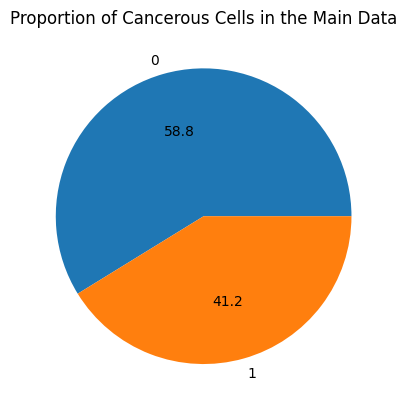

In [9]:
# Display Cancerous and  cell proportions in main dataset
mainData['isCancerous'].value_counts().plot(kind='pie', autopct='%.1f')
plt.title("Proportion of Cancerous Cells in the Main Data")
plt.ylabel("")
plt.show()

The Proportion of Cancerous and Non-Cancerous Cells is relatively balanced in our dataset.

In [10]:
mainData.cellTypeName.value_counts()

cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64

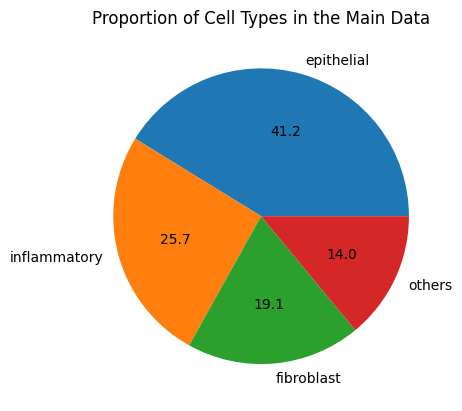

In [11]:
# Display Cancerous and  cell proportions in main dataset
mainData['cellTypeName'].value_counts().plot(kind='pie', autopct='%.1f')
plt.title("Proportion of Cell Types in the Main Data")
plt.ylabel("")
plt.show()

Epithelial Cells take up the majority, followed by Inflammatory, Fibroblast and Others all 3 of which share similar proportions.

<Axes: title={'center': 'Frequency of cell types'}, xlabel='Cell Type', ylabel='Number of Images'>

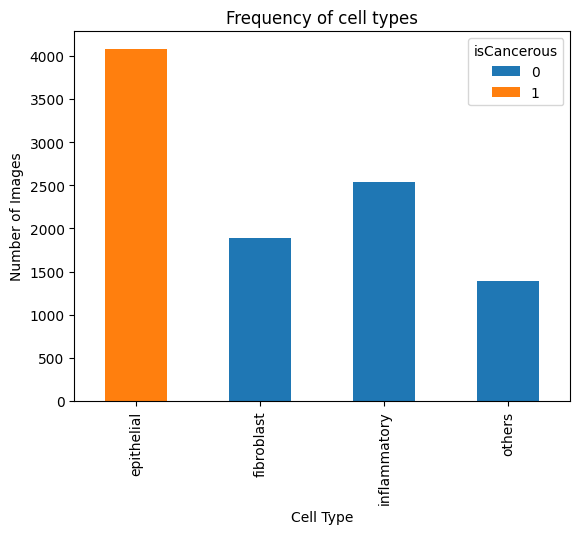

In [14]:
pd.crosstab(mainData['cellTypeName'], mainData['isCancerous'], margins=False).plot.bar(stacked=True,
                                                                                         title='Frequency of cell types',
                                                                                         xlabel='Cell Type',
                                                                                         ylabel='Number of Images')

All cancerous cells in the main dataset are of Epithelial type. This could potentially pose a challenge as it does not correlate to our real-world knowledge. None of the cell types contain a mixture of normal and cancerous cells, which might create misleading information. [CHANGE THIS]

In [17]:
df1 = mainData.groupby(['cellTypeName', 'cellType'])['InstanceID'].nunique()
df2 = mainData.groupby(['isCancerous'])['InstanceID'].nunique()
print(df1)
print(df2)

cellTypeName  cellType
epithelial    2           4079
fibroblast    0           1888
inflammatory  1           2543
others        3           1386
Name: InstanceID, dtype: int64
isCancerous
0    5817
1    4079
Name: InstanceID, dtype: int64


In [18]:
label_names = {k: v for k, v in df1.keys()}
cellTypes = {v: k for k, v in label_names.items()}
print(label_names)
print(cellTypes)

{'epithelial': 2, 'fibroblast': 0, 'inflammatory': 1, 'others': 3}
{2: 'epithelial', 0: 'fibroblast', 1: 'inflammatory', 3: 'others'}


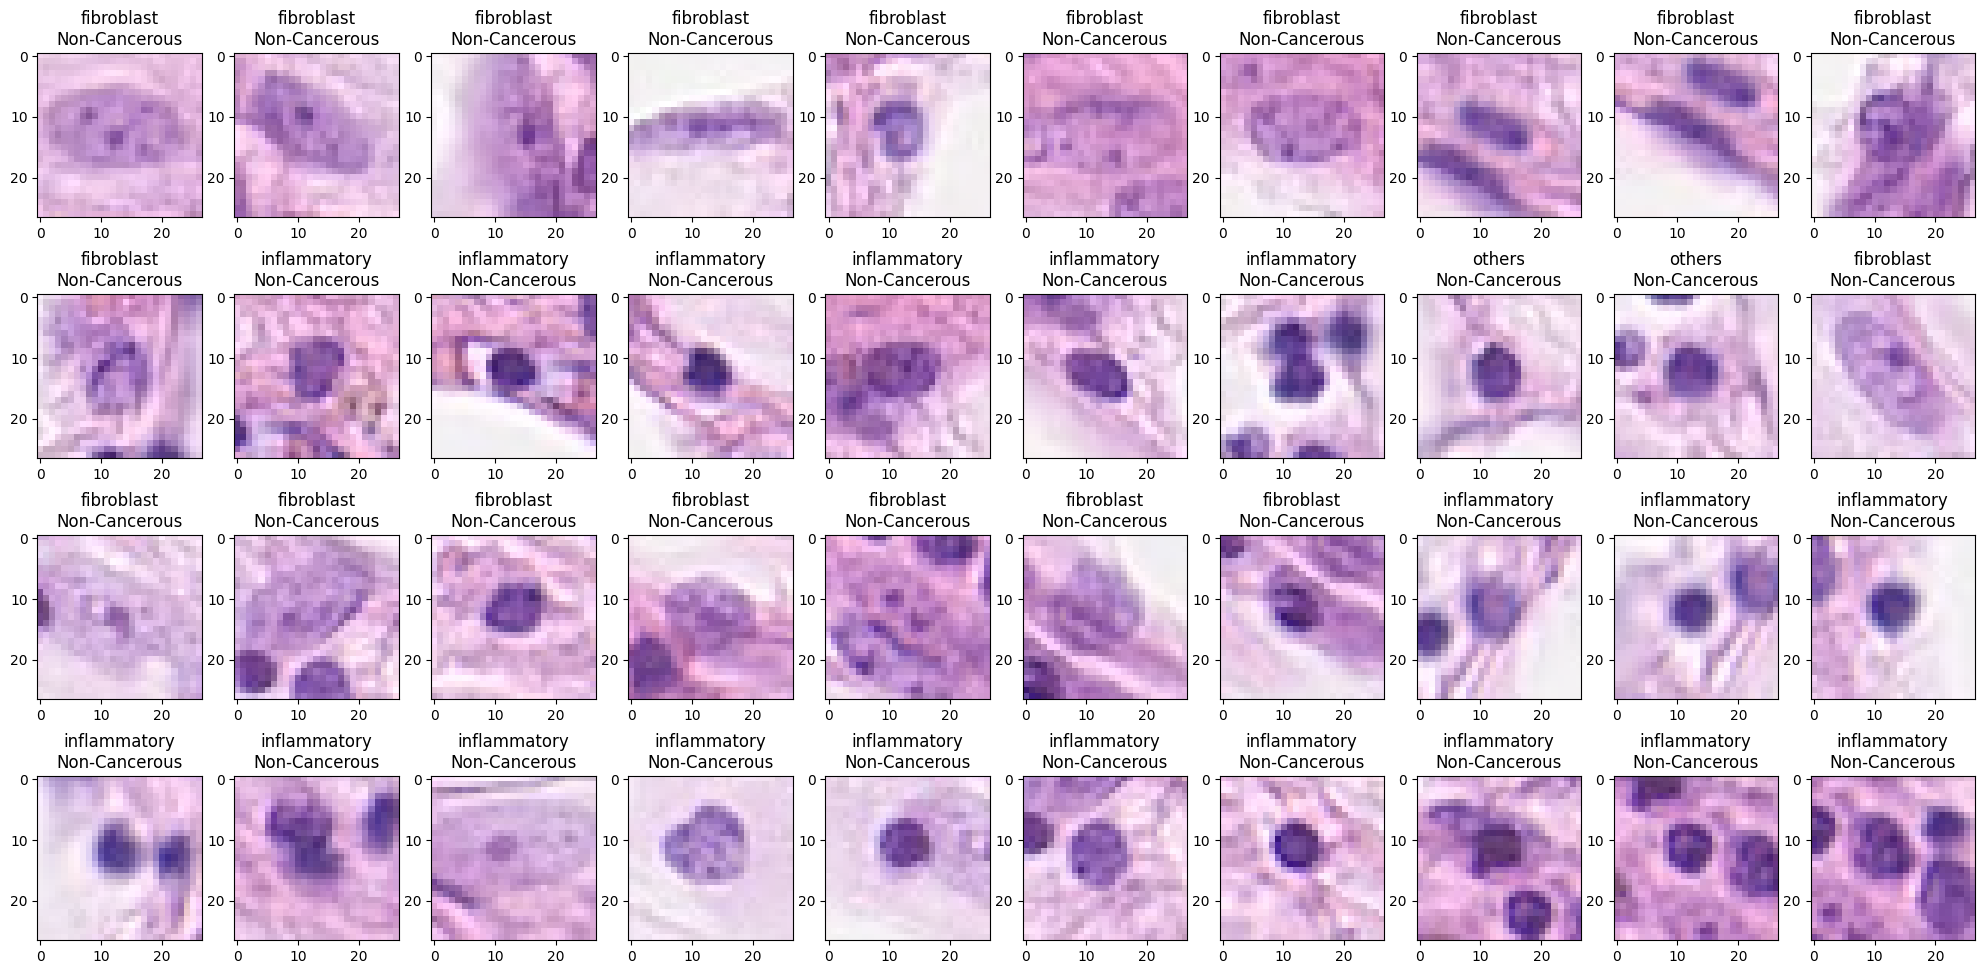

In [19]:
img_list = list(mainData["ImageName"])
types = list(mainData["cellType"])
target_list = list(mainData["isCancerous"])
target_labels = {1: "Cancerous", 0: "Non-Cancerous"}

plt.figure(figsize=[25, 12])

for i in np.arange(40):
    plt.subplot(4, 10, i + 1)
    img = Image.open('./patch_images/' + img_list[i])

    plt.imshow(img)
    plt.title(cellTypes[types[i]] + "\n" + target_labels[target_list[i]])

In [20]:
# Check image sizes
img = Image.open('./patch_images/' + img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print("Image size: \nH:{} W:{} C:{}".format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size: 
H:27 W:27 C:3


The images have a very low resolution of 27x27.

## Data PreProcessing: [CAN DO AFTER SPLIT]?

Our Data does requires very little preprocessing as confirmed by the EDA.

In [6]:
mainData['cellType'] = mainData['cellType'].astype('category')
mainData['cellTypeName'] = mainData['cellTypeName'].astype('category')

Convert the columns 'cellType' and 'cellTypeName' in the DataFrame mainData to categorical data type. This is done to:

- Increase Memory Efficiency
- Improve Performance and Analysis

In [21]:
mainData['isCancerous'] = mainData['isCancerous'].astype('str')

Convert the column 'isCancerous' in the DataFrame mainData to the string data type.

## Splitting the Dataset:

Initially, the mainData DataFrame is split into training and test sets with a test size of 20% (test_size=0.2) and a random state of 42 (random_state=42). The resulting training data is then further split into training and validation sets, with a validation size of 25% (test_size=0.25) and the same random state of 42

In [24]:
train_data, test_data = train_test_split(mainData, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [11]:
train_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
9533,22266,58,22266.png,fibroblast,0,0
310,18717,4,18717.png,others,3,0
9480,21202,57,21202.png,inflammatory,1,0
7073,18114,44,18114.png,fibroblast,0,0
8977,14070,54,14070.png,epithelial,2,1


[CHANGE THIS] The dataset is split into 3 parts.

## Data Preprocessing?

Note: [CHANGE THIS ] Could add Data Augmentation here - but initial trials showed no real improvement for a lot of extra traing time

In [30]:
# We are rescaling the pixel values of the images by dividing them by 255, which brings them into the range of 0 to 1. This step is performed to normalize the pixel values.
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    data_format='channels_last',
)

val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# Note: Sirinukunwattana 2016 and co arbitrary rotated patches (0, 90, 180, 270) and flipped them along vertical or horizontal axis
batch_size = 32

# Generate batches of augmented training data
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

# Generate batches of validation data
validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

# Generate batches of testing data
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


#### Function Definitions:

- Plot the Learning Curve

In [35]:
#     Function to plot the learning curves of training loss, validation loss, training metric, and validation metric.

#     Parameters:
#     train_loss (list): List of training loss values at each epoch.
#     val_loss (list): List of validation loss values at each epoch.
#     train_metric (list): List of training metric values (e.g., accuracy) at each epoch.
#     val_metric (list): List of validation metric values (e.g., accuracy) at each epoch.
#     metric_name (str): Name of the metric to be plotted on the y-axis of the second subplot. Default is 'Accuracy'.

def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    
    # Create a figure with two subplots
    plt.figure(figsize=(10,5))
    
    # Plot training and validation loss
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    # Plot training and validation metric
    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    # Display the plot
    plt.show()

- Fitting the Model
    - ` Please Note that the number of epochs has been set to '100' in early stopping to reduce the time taken to run the models.`

In [40]:
early_stopping_monitor = EarlyStopping(patience=25, monitor='val_categorical_accuracy')

#     Function to train the model using the provided training and validation generators.

#     Parameters:
#     model (tf.keras.Model): The model to be trained.
#     train_gen (tf.keras.preprocessing.image.DataFrameIterator): The training data generator.
#     val_gen (tf.keras.preprocessing.image.DataFrameIterator): The validation data generator.

#     Returns:
#     fit_history (tf.keras.callbacks.History): The history object containing training metrics.

def fitModel(model, train_gen=train_generator, val_gen=validation_generator):
    
    # Get the current time
    now = datetime.datetime.now()
    
     # Fit the model using the training generator and validate on the validation generator
    fit_history = model.fit(train_generator, validation_data = validation_generator, 
                            callbacks=[early_stopping_monitor], epochs=100, verbose=1)
    
    # Print the time taken to compile the model
    print("Time Taken to Compile the Model = ", datetime.datetime.now() - now)
    
    return fit_history

- Plotting the Confusion Matrix

In [42]:

#     Function to plot the confusion matrix based on the predicted and true labels.

#     Parameters:
#     y_test (list or array-like): The true labels.
#     y_pred (list or array-like): The predicted labels.

#     Returns:
#     sns.heatmap: The plotted confusion matrix.

def plotConfusionMatrix(y_test,y_pred):
    
    # Compute the confusion matrix
    conf_data = confusion_matrix(y_test,y_pred)
    
    # Create a DataFrame for the confusion matrix
    df_cm = pd.DataFrame(conf_data, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    
    # Set the font scale for better readability
    sns.set(font_scale=1.4)

    # Plot the confusion matrix using seaborn
    return sns.heatmap(df_cm, cmap="Blues",annot=True,square=True,annot_kws={"size": 16},fmt="g");# font size

- Predicting on the Model

In [44]:
#     Function to make predictions using the trained model on the provided data generator.

#     Parameters:
#     model (tf.keras.Model): The trained model.
#     generator (tf.keras.preprocessing.image.DataFrameIterator): The data generator.

#     Returns:
#     tuple: A tuple containing the true labels (y_test) and predicted labels (y_pred).

def predictModel(model, generator):
    
    # Get the current time
    pr_now = datetime.datetime.now()
    
     # Initialize empty lists for storing predictions and labels
    batch_size_ = 1
    y_pred = list()
    y_test = list()
    
    # Get the filenames and number of images in the generator
    filenames = generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    for x,y in generator:
            yp = model.predict(x, verbose=0)
            yp = np.argmax(yp, axis = 1)
            yt = np.argmax(y, axis = 1)
            y_pred = y_pred + yp.tolist()
            y_test = y_test + yt.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                break
                
    # Print the time taken to predict
    print("Time Taken to Predict the Model = ", datetime.datetime.now() - pr_now)            
    return (y_test, y_pred)

- Print Various Metrics (F1, Accuracy, Recall, etc.)

In [45]:
#     Function to display the evaluation metrics based on the true and predicted labels.

#     Parameters:
#     y_test (list or array-like): The true labels.
#     y_pred (list or array-like): The predicted labels.

def showMetrics(y_test, y_pred):
    
    # Compute the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Compute the F1 score
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Compute the classification report
    cm = classification_report(y_test, y_pred, zero_division=0)

    # Print the accuracy score
    print("Accuracy score: ", accuracy_score(y_test, y_pred))
    # Print the F1 score
    print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
    # Print the classification report
    print(cm)

In [46]:
# Define the input dimension for the image data
INPUT_DIM = (27, 27, 3)

# Define the dimension of the hidden layer in the model
HIDDEN_LAYER_DIM = 256

# Define the number of output classes in the classification task
OUTPUT_CLASSES = 2

## Setup and Exploration of various Machine Learning Models and Algorithms:

We considered several factors such as performance, complexity, and relevance to the task (As highlighted in the report). After careful evaluation, we have identified four models that stand out as the best choices for our project.

- Multilayer Perceptron (MLP) 
- VGG, 
- LeNet 
- RCCNet 

each with its own unique characteristics and advantages.

These selected models have demonstrated superior performance in terms of accuracy, precision, recall, and F1-score during our evaluation process. Additionally, their architectural features and adaptability to image classification tasks, especially in the context of the CRCHistoPhenoTypes dataset, making them the most suitable options for our project

## A simple Multi-Layer Perceptron MLP Model:

Initial Observations-
* isCancerous Classification(The two output variables are OneHotEncoded)
* 1 hidden layer with 256 internal nodes
* Loss - Categorical Cross Entropy [CHANGE THIS]
* Metric - categorical_accuracy [CHANGE THIS] 
* A sigmoid activation is used in the last layer (because it outputs values between 0 and 1, which can be interpreted as the probability that the input belongs to the positive class.)

In [47]:
# Create an MLP model using the Sequential API
model_MLP = tf.keras.Sequential([
    # Flatten the input shape to a 1D array
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # Add a dense layer with 256 units and ReLU activation function
    tf.keras.layers.Dense(256, activation='relu'),
     # Add the output layer with the number of classes and sigmoid activation function
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [48]:
# Compile the MLP model
model_MLP.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),# Set the optimizer with a learning rate of 0.01
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), # Use binary crossentropy as the loss function
              metrics=['categorical_accuracy'])# Track categorical accuracy as a metric

In [20]:
# Fit the MLP model and save the training history
history_MLP = fitModel(model_MLP)

Epoch 1/100
186/186 [==============================] - 30s 161ms/step - loss: 0.6038 - categorical_accuracy: 0.6736 - val_loss: 0.6705 - val_categorical_accuracy: 0.6033
Epoch 2/100
186/186 [==============================] - 2s 12ms/step - loss: 0.4813 - categorical_accuracy: 0.7773 - val_loss: 0.4050 - val_categorical_accuracy: 0.8621
Epoch 3/100
186/186 [==============================] - 2s 12ms/step - loss: 0.4198 - categorical_accuracy: 0.8181 - val_loss: 0.7842 - val_categorical_accuracy: 0.6362
Epoch 4/100
186/186 [==============================] - 2s 12ms/step - loss: 0.3972 - categorical_accuracy: 0.8272 - val_loss: 0.3476 - val_categorical_accuracy: 0.8646
Epoch 5/100
186/186 [==============================] - 2s 12ms/step - loss: 0.3613 - categorical_accuracy: 0.8477 - val_loss: 0.3279 - val_categorical_accuracy: 0.8681
Epoch 6/100
186/186 [==============================] - 2s 12ms/step - loss: 0.3668 - categorical_accuracy: 0.8417 - val_loss: 0.3321 - val_categorical_accurac

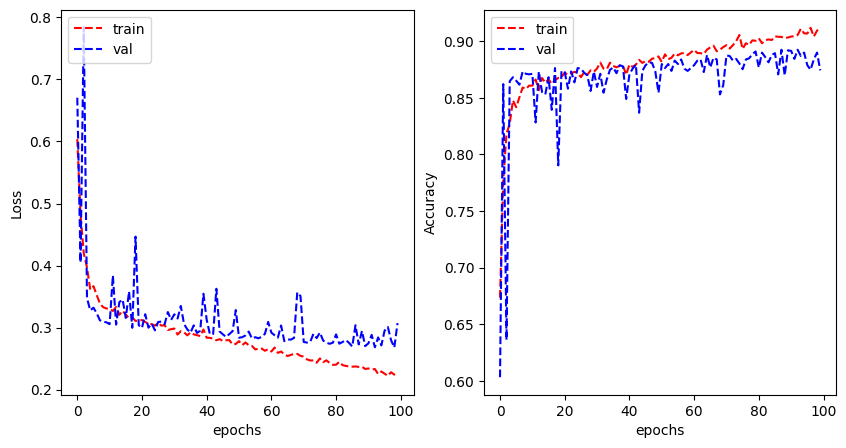

In [21]:
# Plot the learning curve for the MLP model
plot_learning_curve(history_MLP.history['loss'], history_MLP.history['val_loss'], 
                    history_MLP.history['categorical_accuracy'], history_MLP.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [22]:
# Predict the output labels for the training data using the MLP model
(train_y, train_MLP_pred_y) = predictModel(model_MLP, train_generator)

Time Taken to Predict the Model =  0:04:29.823943


In [23]:
# Predict the output labels for the validation data using the MLP model
(val_y, val_MLP_pred_y) = predictModel(model_MLP, validation_generator)

Time Taken to Predict the Model =  0:01:46.133714


In [24]:
# Predict the output labels for the test data using the MLP model
(test_y, test_MLP_pred_y) = predictModel(model_MLP, test_generator)

Time Taken to Predict the Model =  0:02:04.983985


In [25]:
# Calculate and display evaluation metrics for the MLP model on the training data
showMetrics(train_y, train_MLP_pred_y)

Accuracy score:  0.9058880639935838
F1 score:  0.9010372279262837
              precision    recall  f1-score   support

           0       0.88      0.97      0.92    110393
           1       0.95      0.82      0.88     79126

    accuracy                           0.91    189519
   macro avg       0.92      0.89      0.90    189519
weighted avg       0.91      0.91      0.90    189519



In [26]:
# Calculate and display evaluation metrics for the MLP model on the validation data
showMetrics(val_y, val_MLP_pred_y)

Accuracy score:  0.8741392683583177
F1 score:  0.8670250678445439
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     37312
           1       0.89      0.79      0.84     25861

    accuracy                           0.87     63173
   macro avg       0.88      0.86      0.87     63173
weighted avg       0.88      0.87      0.87     63173



In [27]:
# Calculate and display evaluation metrics for the MLP model on the test data
showMetrics(test_y, test_MLP_pred_y)

Accuracy score:  0.8666740464292492
F1 score:  0.8574435704228618
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     37970
           1       0.88      0.77      0.82     25266

    accuracy                           0.87     63236
   macro avg       0.87      0.85      0.86     63236
weighted avg       0.87      0.87      0.86     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

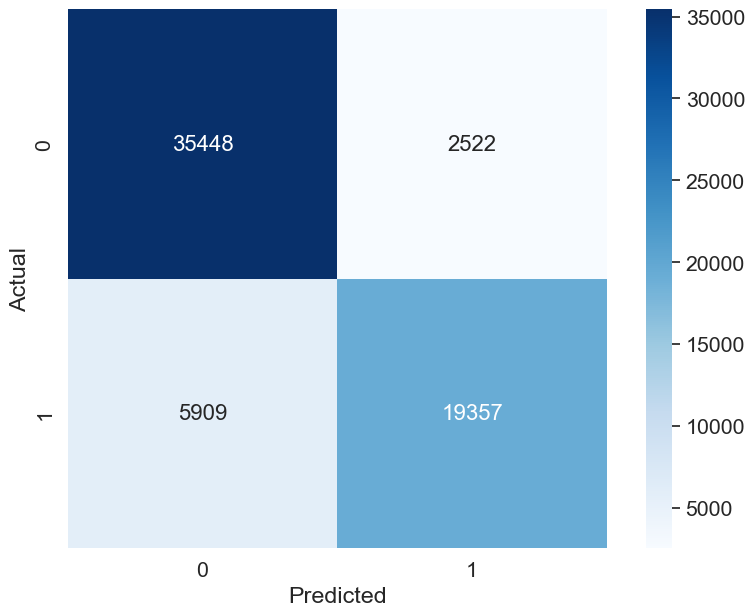

In [28]:
# Plot the confusion matrix for the MLP model's predictions on the test data
plotConfusionMatrix(test_y, test_MLP_pred_y)

Key Observations:-
- Overfitting: The model shows signs of overfitting as the performance on the training data is better than that on the validation and test data.

- Class Imbalance: The model generally performs better on class 0, which has a larger number of samples, compared to class 1. This suggests the presence of class imbalance, where the model may struggle to accurately predict the minority class due to its relatively lower representation in the dataset.

The accuracy, precision, recall, and F1 scores on these datasets are still relatively high, indicating that the model can generalize to some extent and make accurate predictions on new and unseen data. The MLP model serves as a good starting point for the classification task, but further model improvement techniques should be considered to address the observed overfitting and class imbalance. Techniques such as regularization, dropout are used further to try and improve the model.

## MLP + L2 Regularisation:

In [29]:
reg_lambda = 0.01

model_MLP_REG = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [30]:
model_MLP_REG.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [31]:
history_MLP_REG = fitModel(model_MLP_REG)

Epoch 1/100
186/186 [==============================] - 9s 47ms/step - loss: 5.0587 - categorical_accuracy: 0.6835 - val_loss: 4.8028 - val_categorical_accuracy: 0.7660
Epoch 2/100
186/186 [==============================] - 9s 48ms/step - loss: 4.6487 - categorical_accuracy: 0.7704 - val_loss: 4.4212 - val_categorical_accuracy: 0.8535
Epoch 3/100
186/186 [==============================] - 9s 48ms/step - loss: 4.2965 - categorical_accuracy: 0.8065 - val_loss: 4.1024 - val_categorical_accuracy: 0.8646
Epoch 4/100
186/186 [==============================] - 9s 48ms/step - loss: 3.9941 - categorical_accuracy: 0.8306 - val_loss: 3.8219 - val_categorical_accuracy: 0.8676
Epoch 5/100
186/186 [==============================] - 9s 49ms/step - loss: 3.7294 - categorical_accuracy: 0.8294 - val_loss: 3.6137 - val_categorical_accuracy: 0.8343
Epoch 6/100
186/186 [==============================] - 9s 48ms/step - loss: 3.4771 - categorical_accuracy: 0.8461 - val_loss: 3.3353 - val_categorical_accuracy:

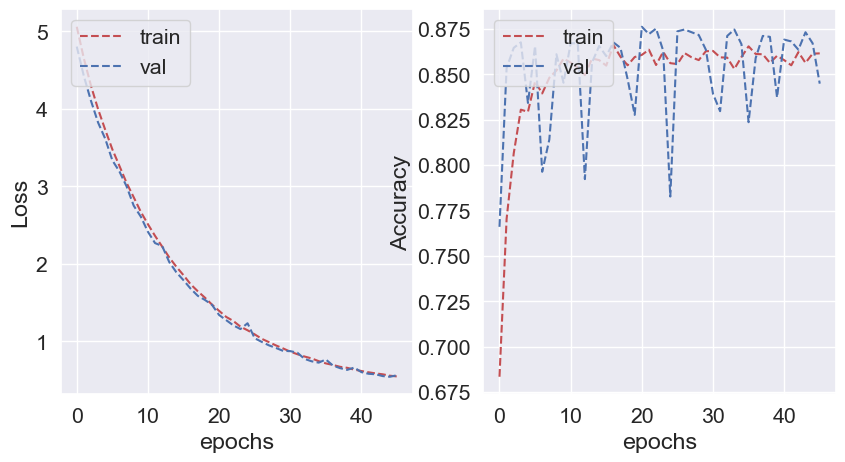

In [32]:
plot_learning_curve(history_MLP_REG.history['loss'], history_MLP_REG.history['val_loss'], 
                    history_MLP_REG.history['categorical_accuracy'], history_MLP_REG.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [33]:
(train_y, train_MLP_REG_pred_y) = predictModel(model_MLP_REG, train_generator)

Time Taken to Predict the Model =  0:08:25.249969


In [34]:
(val_y, val_MLP_REG_pred_y) = predictModel(model_MLP_REG, validation_generator)

Time Taken to Predict the Model =  0:03:27.240577


In [35]:
(test_y, test_MLP_REG_pred_y) = predictModel(model_MLP_REG, test_generator)

Time Taken to Predict the Model =  0:04:09.327184


In [36]:
showMetrics(train_y, train_MLP_REG_pred_y)

Accuracy score:  0.8473277608915907
F1 score:  0.8465897330189749
              precision    recall  f1-score   support

           0       0.94      0.79      0.86    110395
           1       0.76      0.93      0.84     79109

    accuracy                           0.85    189504
   macro avg       0.85      0.86      0.85    189504
weighted avg       0.86      0.85      0.85    189504



In [37]:
showMetrics(val_y, val_MLP_REG_pred_y)

Accuracy score:  0.8449531408308004
F1 score:  0.843776537514205
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     37301
           1       0.75      0.93      0.83     25867

    accuracy                           0.84     63168
   macro avg       0.85      0.86      0.84     63168
weighted avg       0.86      0.84      0.85     63168



In [38]:
showMetrics(test_y, test_MLP_REG_pred_y)

Accuracy score:  0.8546621963562753
F1 score:  0.8528116840845266
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     37970
           1       0.76      0.93      0.84     25262

    accuracy                           0.85     63232
   macro avg       0.85      0.87      0.85     63232
weighted avg       0.87      0.85      0.86     63232



<Axes: xlabel='Predicted', ylabel='Actual'>

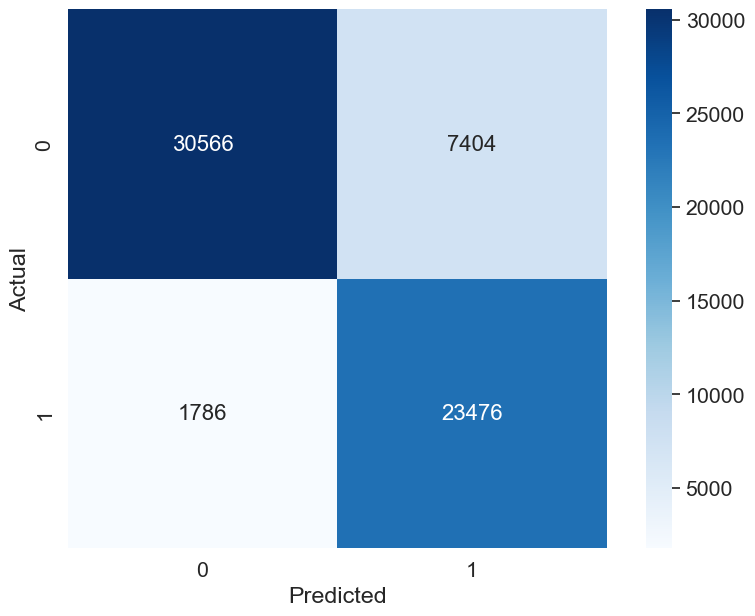

In [39]:
plotConfusionMatrix(test_y, test_MLP_REG_pred_y)

Key Observations:-

- Regularization Effect: The addition of regularization techniques has helped alleviate the overfitting issue observed in the previous MLP model. The performance on the training data has slightly decreased, indicating that regularization has effectively controlled the model's tendency to memorize the training data and improved its ability to generalize.

- Class Imbalance: Similar to the previous model, there is a noticeable performance difference between the majority class (0, non-cancerous) and the minority class (1, cancerous). 

- Model Stability: The regularization has contributed to a more stable model performance, as indicated by the consistency of evaluation metrics across the training, validation, and test data. 

Although the regularization has brought positive changes, there is still room for improvement in addressing the class imbalance and enhancing the model's performance on the cancerous class as discussed further.

## MLP + Dropout

In [40]:
model_MLP_DRP = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [41]:
model_MLP_DRP.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [42]:
history_MLP_DRP = fitModel(model_MLP_DRP)

Epoch 1/100
186/186 [==============================] - 23s 121ms/step - loss: 0.6170 - categorical_accuracy: 0.6692 - val_loss: 0.5231 - val_categorical_accuracy: 0.8327
Epoch 2/100
186/186 [==============================] - 26s 138ms/step - loss: 0.4899 - categorical_accuracy: 0.7851 - val_loss: 0.4248 - val_categorical_accuracy: 0.8065
Epoch 3/100
186/186 [==============================] - 23s 124ms/step - loss: 0.4360 - categorical_accuracy: 0.8066 - val_loss: 0.5195 - val_categorical_accuracy: 0.7251
Epoch 4/100
186/186 [==============================] - 22s 120ms/step - loss: 0.4079 - categorical_accuracy: 0.8260 - val_loss: 0.3728 - val_categorical_accuracy: 0.8525
Epoch 5/100
186/186 [==============================] - 23s 123ms/step - loss: 0.3742 - categorical_accuracy: 0.8415 - val_loss: 0.3542 - val_categorical_accuracy: 0.8439
Epoch 6/100
186/186 [==============================] - 24s 126ms/step - loss: 0.3655 - categorical_accuracy: 0.8449 - val_loss: 0.3220 - val_categoric

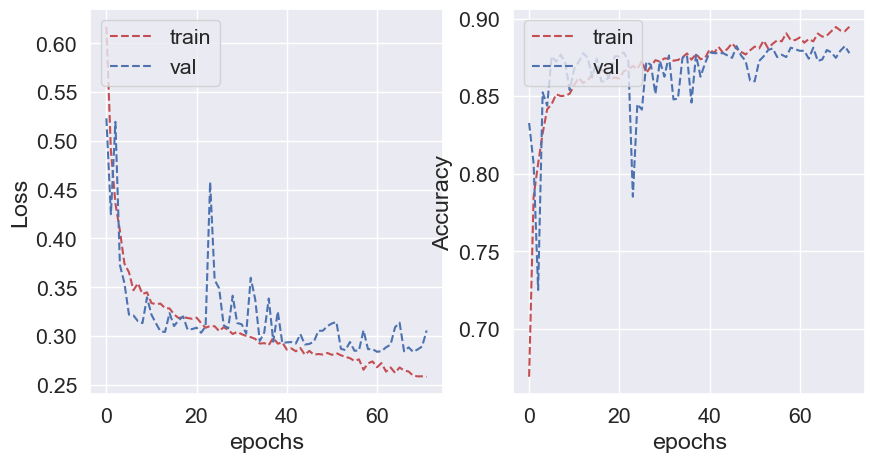

In [43]:
plot_learning_curve(history_MLP_DRP.history['loss'], history_MLP_DRP.history['val_loss'], 
                    history_MLP_DRP.history['categorical_accuracy'], history_MLP_DRP.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [44]:
(train_y, train_MLP_DRP_pred_y) = predictModel(model_MLP_DRP, train_generator)

Time Taken to Predict the Model =  0:14:28.485997


In [45]:
(val_y, val_MLP_DRP_pred_y) = predictModel(model_MLP_DRP, validation_generator)

Time Taken to Predict the Model =  0:05:50.258912


In [46]:
(test_y, test_MLP_DRP_pred_y) = predictModel(model_MLP_DRP, test_generator)

Time Taken to Predict the Model =  0:06:13.462805


In [47]:
showMetrics(train_y, train_MLP_DRP_pred_y)

Accuracy score:  0.8932476359338062
F1 score:  0.8880277629920394
              precision    recall  f1-score   support

           0       0.88      0.95      0.91    110389
           1       0.92      0.81      0.86     79115

    accuracy                           0.89    189504
   macro avg       0.90      0.88      0.89    189504
weighted avg       0.90      0.89      0.89    189504



In [48]:
showMetrics(val_y, val_MLP_DRP_pred_y)

Accuracy score:  0.8777862208713273
F1 score:  0.8707766714415417
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     37314
           1       0.90      0.79      0.84     25854

    accuracy                           0.88     63168
   macro avg       0.88      0.86      0.87     63168
weighted avg       0.88      0.88      0.88     63168



In [49]:
showMetrics(test_y, test_MLP_DRP_pred_y)

Accuracy score:  0.8645780617408907
F1 score:  0.8552758001505856
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     37969
           1       0.88      0.76      0.82     25263

    accuracy                           0.86     63232
   macro avg       0.87      0.85      0.86     63232
weighted avg       0.87      0.86      0.86     63232



<Axes: xlabel='Predicted', ylabel='Actual'>

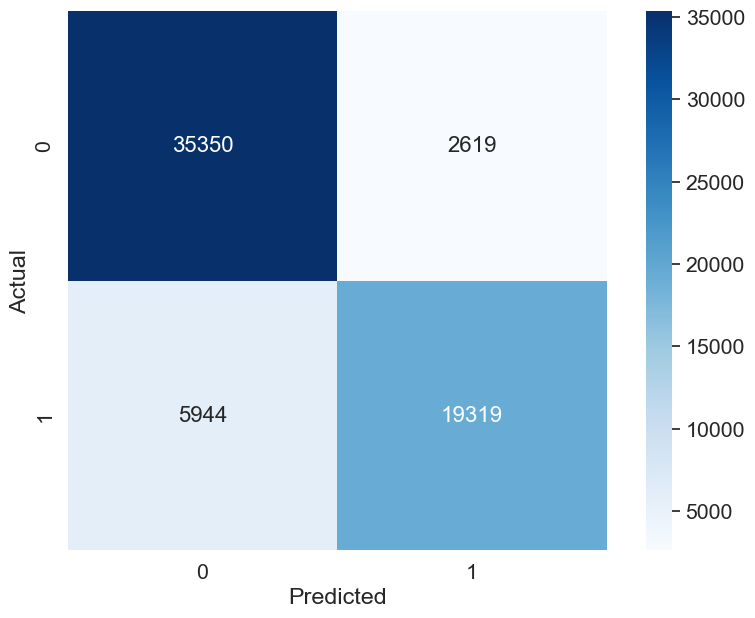

In [50]:
plotConfusionMatrix(test_y, test_MLP_DRP_pred_y)

Key Observations:-

- Regularization Effect: The addition of Dropout regularization has improved the generalization capability of the MLP model

- Generalization Improvement: The model's performance on the validation and test data has improved compared to the previous MLP models.

- Model Stability: Dropout regularization has contributed to a stable model performance, as indicated by the consistency of evaluation metrics across the training, validation, and test data. 

- Adaptability to Class Imbalance: Dropout regularization helped address the class imbalance to some extent. By randomly dropping out neurons, Dropout provided equal opportunities for different classes to contribute to the model's decision-making process. This improved the model's ability to learn from both the majority and minority classes, leading to more balanced performance metrics for the cancerous class.

 Dropout regularization proved to be effective in improving the performance of the MLP model by reducing overfitting, capturing complex relationships, increasing stability, and adapting to class imbalance. It has outperformed both our previous MLP Models. Hence, it is further worth exploring HyperParamter Tuning on this model to try and improve performance even more.

## MLP + Dropout + Hyperparamter Tuning:

In [18]:
from tensorflow.keras import layers
from keras_tuner import RandomSearch

# Define the model-building function
def build_mlp(hp):
    dropout = hp.Choice('dropout', values=[0.1, 0.2])
    num_neurons = hp.Choice('num_neurons', values=[128, 256])
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01])

    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(num_neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['categorical_accuracy'])
    return model

In [19]:
tuner = RandomSearch(
    build_mlp,
    objective='val_categorical_accuracy',
    max_trials=8,  # Adjust this value as desired
    executions_per_trial=1,
    directory='tuner_directory',  # Provide a directory to store tuner results
    project_name='mlp_hyperparameter_tuning_1'  # Choose a project name
)

# Perform the hyperparameter search
tuner.search(train_generator, epochs=20, validation_data=validation_generator)

# Get the best hyperparameters and model architecture
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_MLP = tuner.get_best_models(num_models=1)[0]

Trial 8 Complete [00h 00m 46s]
val_categorical_accuracy: 0.8585144281387329

Best val_categorical_accuracy So Far: 0.878221333026886
Total elapsed time: 00h 06m 46s
INFO:tensorflow:Oracle triggered exit


In [20]:
history_MLP_best = fitModel(best_MLP)

Epoch 1/100
186/186 [==============================] - 3s 12ms/step - loss: 0.3351 - categorical_accuracy: 0.8563 - val_loss: 0.3125 - val_categorical_accuracy: 0.8681
Epoch 2/100
186/186 [==============================] - 2s 13ms/step - loss: 0.3283 - categorical_accuracy: 0.8621 - val_loss: 0.3112 - val_categorical_accuracy: 0.8666
Epoch 3/100
186/186 [==============================] - 2s 13ms/step - loss: 0.3290 - categorical_accuracy: 0.8607 - val_loss: 0.3219 - val_categorical_accuracy: 0.8641
Epoch 4/100
186/186 [==============================] - 2s 13ms/step - loss: 0.3274 - categorical_accuracy: 0.8578 - val_loss: 0.3059 - val_categorical_accuracy: 0.8782
Epoch 5/100
186/186 [==============================] - 2s 13ms/step - loss: 0.3252 - categorical_accuracy: 0.8631 - val_loss: 0.3047 - val_categorical_accuracy: 0.8752
Epoch 6/100
186/186 [==============================] - 2s 13ms/step - loss: 0.3190 - categorical_accuracy: 0.8602 - val_loss: 0.3426 - val_categorical_accuracy:

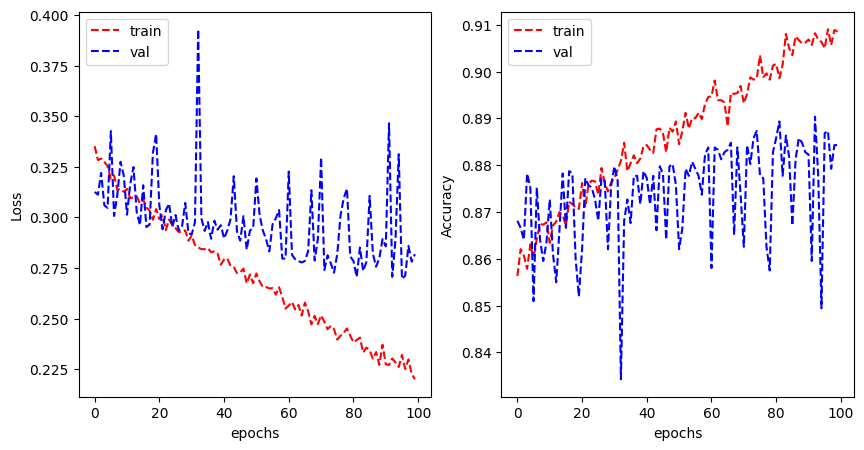

In [21]:
plot_learning_curve(history_MLP_best.history['loss'], history_MLP_best.history['val_loss'], 
                    history_MLP_best.history['categorical_accuracy'], history_MLP_best.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [22]:
(train_y, train_MLP_best_pred_y) = predictModel(best_MLP, train_generator)

Time Taken to Predict the Model =  0:04:51.904390


In [23]:
(val_y, val_MLP_best_pred_y) = predictModel(best_MLP, validation_generator)

Time Taken to Predict the Model =  0:01:52.843999


In [24]:
(test_y, test_MLP_best_pred_y) = predictModel(best_MLP, test_generator)

Time Taken to Predict the Model =  0:02:19.830471


In [25]:
showMetrics(train_y, train_MLP_best_pred_y)

Accuracy score:  0.9078720339385496
F1 score:  0.9063214004661002
              precision    recall  f1-score   support

           0       0.95      0.89      0.92    110413
           1       0.86      0.93      0.89     79106

    accuracy                           0.91    189519
   macro avg       0.90      0.91      0.91    189519
weighted avg       0.91      0.91      0.91    189519



In [26]:
showMetrics(val_y, val_MLP_best_pred_y)

Accuracy score:  0.8843493264527568
F1 score:  0.8817710406923116
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     37320
           1       0.83      0.90      0.86     25853

    accuracy                           0.88     63173
   macro avg       0.88      0.89      0.88     63173
weighted avg       0.89      0.88      0.88     63173



In [27]:
showMetrics(test_y, test_MLP_best_pred_y)

Accuracy score:  0.8832785122398634
F1 score:  0.8801724601384469
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     37972
           1       0.82      0.90      0.86     25264

    accuracy                           0.88     63236
   macro avg       0.88      0.89      0.88     63236
weighted avg       0.89      0.88      0.88     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

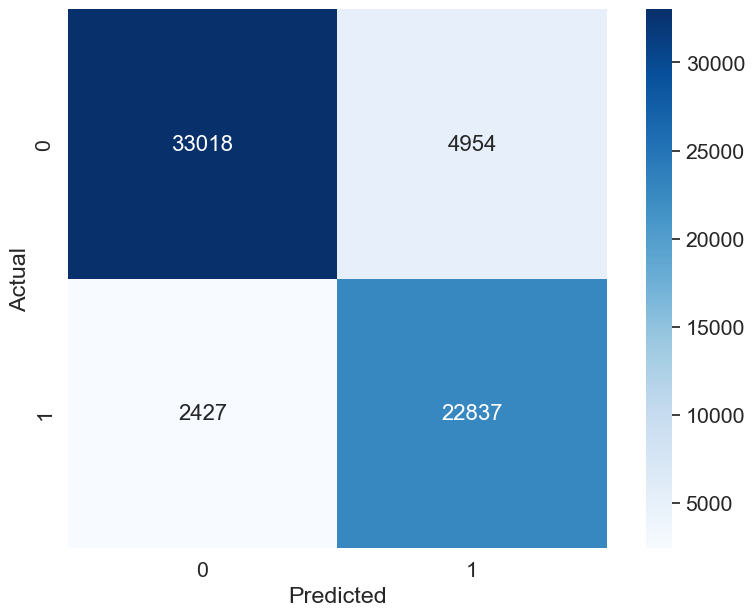

In [28]:
plotConfusionMatrix(test_y, test_MLP_best_pred_y)

Key Observations:-

- Improved Performance: The model with Dropout and optimized hyperparameters achieved higher accuracy, precision, recall, and F1 scores on the training, validation, and test datasets compared to the previous models. 

- Generalization and Robustness: The model demonstrated good generalization ability with consistent performance across different datasets. 

- Handling Class Imbalance: The model's performance for both the majority (non-cancerous) and minority (cancerous) classes improved. The F1 scores, precision, and recall for the cancerous class increased, indicating that the model became better at detecting cancerous cases while maintaining high performance for non-cancerous cases.

- Trade-off between Precision and Recall: The model achieved relatively high precision and recall for both classes, striking a balance between correctly identifying cancerous cases (recall) and minimizing false positives (precision). This balance is crucial in medical applications, where both avoiding false negatives and minimizing unnecessary treatments are important.

- Optimized Hyperparameters: The hyperparameter tuning process likely helped the model find the optimal values for hyperparameters such as learning rate, batch size, number of hidden units, etc. 

Overall, by combining Dropout regularization with hyperparameter tuning, the MLP model achieved improved performance, generalization, and class balance handling. It demonstrates the effectiveness of these techniques in enhancing the model's ability to accurately classify cancerous and non-cancerous cases. However, There is still room for improvement and we will further consider more advanced Machine Learning Models.

##  VGG (Visual Geometry Group), a convolutional neural network (CNN) architecture:

A 2-block VGG model is relevant to our dataset because it has proven to be effective in capturing hierarchical features in images, which is essential for our computer vision task of classifying cancerous cells.

In [50]:
model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid' )
])

In [51]:
# Compile the VGG-2 model with the specified optimizer, loss function, and evaluation metric
model_VGG_2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [20]:
# Fit the VGG-2 model to the training data
history_VGG_2 = fitModel(model_VGG_2)

Epoch 1/100
186/186 [==============================] - 38s 201ms/step - loss: 0.6737 - categorical_accuracy: 0.5821 - val_loss: 0.6623 - val_categorical_accuracy: 0.5907
Epoch 2/100
186/186 [==============================] - 9s 48ms/step - loss: 0.6588 - categorical_accuracy: 0.5826 - val_loss: 0.6420 - val_categorical_accuracy: 0.5907
Epoch 3/100
186/186 [==============================] - 9s 48ms/step - loss: 0.6260 - categorical_accuracy: 0.6257 - val_loss: 0.6808 - val_categorical_accuracy: 0.4937
Epoch 4/100
186/186 [==============================] - 10s 51ms/step - loss: 0.5745 - categorical_accuracy: 0.7069 - val_loss: 0.5837 - val_categorical_accuracy: 0.6963
Epoch 5/100
186/186 [==============================] - 9s 47ms/step - loss: 0.5310 - categorical_accuracy: 0.7394 - val_loss: 0.5955 - val_categorical_accuracy: 0.6584
Epoch 6/100
186/186 [==============================] - 9s 46ms/step - loss: 0.4875 - categorical_accuracy: 0.7741 - val_loss: 0.4109 - val_categorical_accura

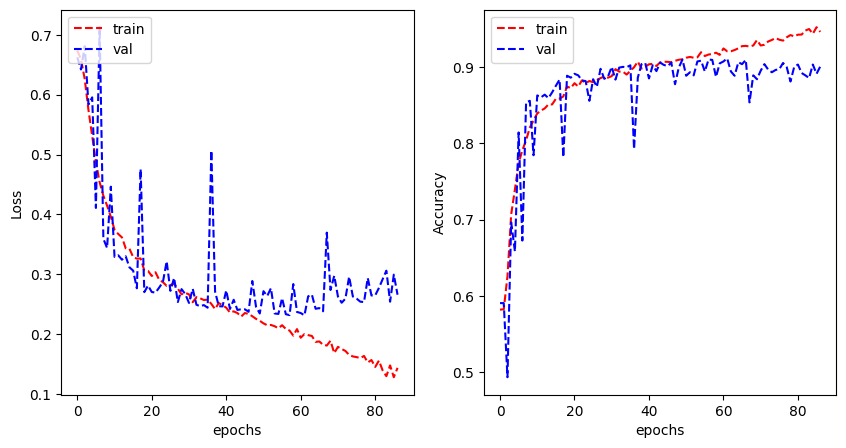

In [21]:
plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [22]:
(train_y, train_VGG_2_pred_y) = predictModel(model_VGG_2, train_generator)

Time Taken to Predict the Model =  0:05:47.685331


In [23]:
(val_y, val_VGG_2_pred_y) = predictModel(model_VGG_2, validation_generator)

Time Taken to Predict the Model =  0:02:46.735974


In [24]:
(test_y, test_VGG_2_pred_y) = predictModel(model_VGG_2, test_generator)

Time Taken to Predict the Model =  0:03:26.183644


In [25]:
showMetrics(train_y, train_VGG_2_pred_y)

Accuracy score:  0.9699027538136018
F1 score:  0.9690185392783706
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    110430
           1       0.97      0.96      0.96     79089

    accuracy                           0.97    189519
   macro avg       0.97      0.97      0.97    189519
weighted avg       0.97      0.97      0.97    189519



In [26]:
showMetrics(val_y, val_VGG_2_pred_y)

Accuracy score:  0.9005271239295268
F1 score:  0.8971208277319807
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     37321
           1       0.88      0.88      0.88     25852

    accuracy                           0.90     63173
   macro avg       0.90      0.90      0.90     63173
weighted avg       0.90      0.90      0.90     63173



In [27]:
showMetrics(test_y, test_VGG_2_pred_y)

Accuracy score:  0.906034537288886
F1 score:  0.9017468475977035
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     37969
           1       0.89      0.87      0.88     25267

    accuracy                           0.91     63236
   macro avg       0.90      0.90      0.90     63236
weighted avg       0.91      0.91      0.91     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

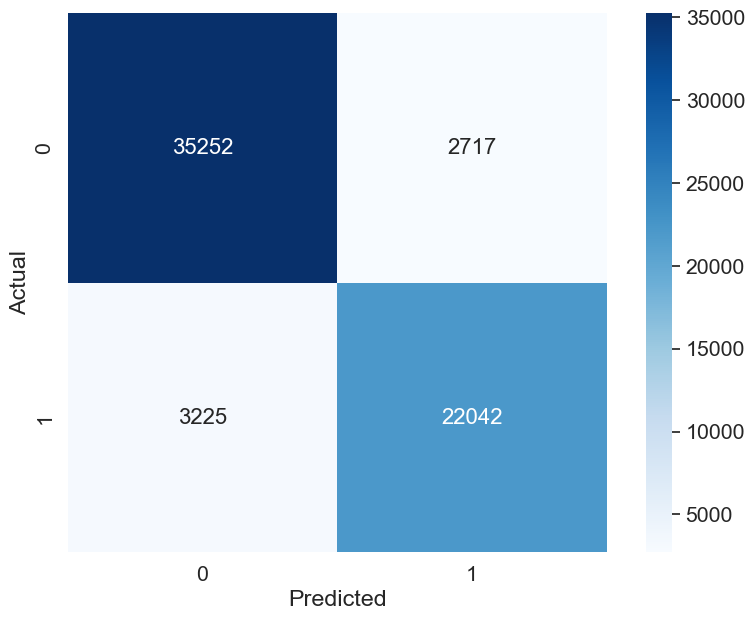

In [28]:
plotConfusionMatrix(test_y, test_VGG_2_pred_y)

Key Observations:

- Effective Feature Extraction: The VGG architecture, with its deeper layers and smaller convolution filters, allowed the model to extract intricate features from the input images. This resulted in improved accuracy, precision, recall, and F1 scores on the training, validation, and test datasets compared to previous models.

- Overfitting Concerns: The substantial variation in performance between the training and validation/test datasets indicates that the model may have become too specialized to the training data, resulting in reduced generalization to unseen samples. 

The VGG architecture outperformed the best MLP model in terms of accuracy, precision, recall, and F1 scores on all datasets. It achieved higher scores for both cancerous and non-cancerous cases, indicating its effectiveness in correctly classifying instances from both classes. However, it can still be improved using regularisation techniques as explored further.

## VGG + Dropout:

In [18]:
reg_lambda = 0.001

model_VGG_reg_drop = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid'),
])

In [19]:
model_VGG_reg_drop.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [20]:
history_VGG_reg_drop = fitModel(model_VGG_reg_drop)

Epoch 1/100
186/186 [==============================] - 39s 206ms/step - loss: 0.6720 - categorical_accuracy: 0.5789 - val_loss: 0.6624 - val_categorical_accuracy: 0.5907
Epoch 2/100
186/186 [==============================] - 9s 47ms/step - loss: 0.6557 - categorical_accuracy: 0.5838 - val_loss: 0.6308 - val_categorical_accuracy: 0.5907
Epoch 3/100
186/186 [==============================] - 9s 48ms/step - loss: 0.6068 - categorical_accuracy: 0.6699 - val_loss: 0.7316 - val_categorical_accuracy: 0.4366
Epoch 4/100
186/186 [==============================] - 9s 51ms/step - loss: 0.5666 - categorical_accuracy: 0.7037 - val_loss: 0.4635 - val_categorical_accuracy: 0.8014
Epoch 5/100
186/186 [==============================] - 10s 52ms/step - loss: 0.5230 - categorical_accuracy: 0.7484 - val_loss: 0.4232 - val_categorical_accuracy: 0.8282
Epoch 6/100
186/186 [==============================] - 9s 48ms/step - loss: 0.4801 - categorical_accuracy: 0.7770 - val_loss: 0.4393 - val_categorical_accura

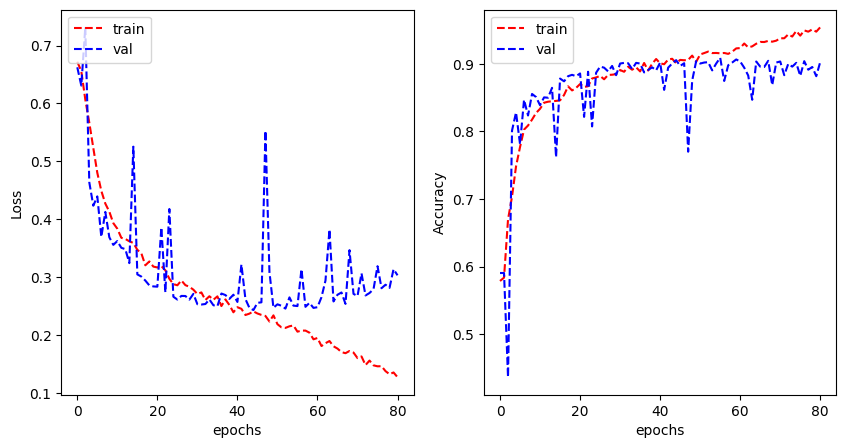

In [21]:
plot_learning_curve(history_VGG_reg_drop.history['loss'], history_VGG_reg_drop.history['val_loss'], 
                    history_VGG_reg_drop.history['categorical_accuracy'], history_VGG_reg_drop.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [22]:
(train_y, train_VGG_reg_drop_pred_y) = predictModel(model_VGG_reg_drop, train_generator)

Time Taken to Predict the Model =  0:05:54.740322


In [23]:
(val_y, val_VGG_reg_drop_pred_y) = predictModel(model_VGG_reg_drop, validation_generator)

Time Taken to Predict the Model =  0:02:45.240705


In [24]:
(test_y, test_VGG_reg_drop_pred_y) = predictModel(model_VGG_reg_drop, test_generator)

Time Taken to Predict the Model =  0:03:28.016309


In [25]:
showMetrics(train_y, train_VGG_reg_drop_pred_y)

Accuracy score:  0.9617874724961614
F1 score:  0.9604350624816116
              precision    recall  f1-score   support

           0       0.95      0.98      0.97    110411
           1       0.98      0.93      0.95     79108

    accuracy                           0.96    189519
   macro avg       0.96      0.96      0.96    189519
weighted avg       0.96      0.96      0.96    189519



In [26]:
showMetrics(val_y, val_VGG_reg_drop_pred_y)

Accuracy score:  0.9029173855919459
F1 score:  0.898454282121061
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     37313
           1       0.91      0.85      0.88     25860

    accuracy                           0.90     63173
   macro avg       0.90      0.89      0.90     63173
weighted avg       0.90      0.90      0.90     63173



In [27]:
showMetrics(test_y, test_VGG_reg_drop_pred_y)

Accuracy score:  0.8964513884496174
F1 score:  0.8906292434328356
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     37970
           1       0.90      0.83      0.87     25266

    accuracy                           0.90     63236
   macro avg       0.90      0.89      0.89     63236
weighted avg       0.90      0.90      0.90     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

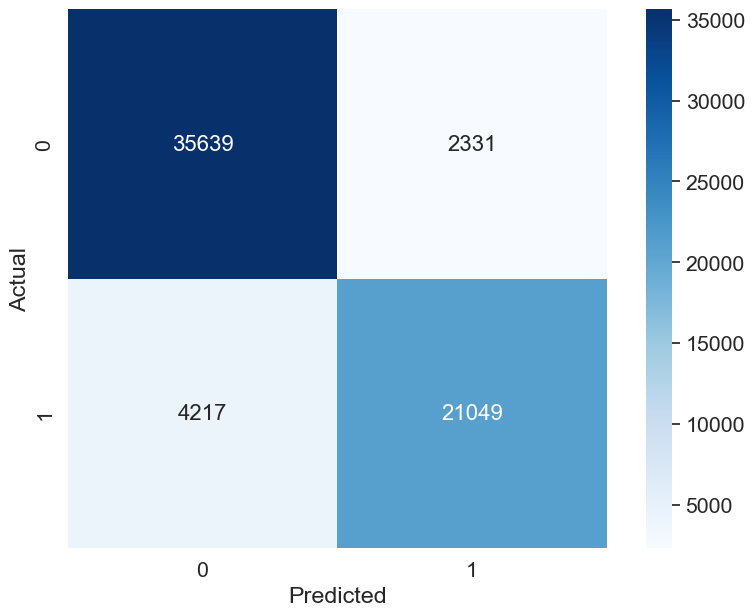

In [28]:
plotConfusionMatrix(test_y, test_VGG_reg_drop_pred_y)

Key Observations:

- Upon applying dropout to the base VGG architecture, it is observed that the performance of the model did not significantly improve compared to the original VGG model. 

This may be due to several factors such as Complexity of the Dataset, Optimal Architecture of the VGG Model or the Chosen Hyperparameter Settings. We will try to Tune our Hyperparameters to try and improved model performance.

## VGG + Dropout + Hyperparameter Tuning:

In [22]:
from tensorflow.keras import layers
from keras_tuner import RandomSearch

def build_VGG(hp):
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.2, step=0.1)
    
    model = tf.keras.Sequential([
        # VGG block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid'),
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01])),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['categorical_accuracy'])
    return model

In [23]:

tuner = RandomSearch(
    build_VGG,
    objective='val_categorical_accuracy',
    max_trials=4,  # Adjust this value as desired
    executions_per_trial=1,
    directory='tuner_directory',  # Provide a directory to store tuner results
    project_name='vgg_hyperparameter_tuning_1'  # Choose a project name
)

# Perform the hyperparameter search
tuner.search(train_generator, epochs=15, validation_data=validation_generator)

# Get the best hyperparameters and model architecture
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_VGG = tuner.get_best_models(num_models=1)[0]

Trial 4 Complete [00h 02m 14s]
val_categorical_accuracy: 0.8792319297790527

Best val_categorical_accuracy So Far: 0.8792319297790527
Total elapsed time: 00h 08m 56s
INFO:tensorflow:Oracle triggered exit


In [24]:
history_VGG_best = fitModel(best_VGG)

Epoch 1/100
186/186 [==============================] - 9s 47ms/step - loss: 0.3354 - categorical_accuracy: 0.8509 - val_loss: 0.3005 - val_categorical_accuracy: 0.8787
Epoch 2/100
186/186 [==============================] - 9s 47ms/step - loss: 0.3212 - categorical_accuracy: 0.8646 - val_loss: 0.4071 - val_categorical_accuracy: 0.8110
Epoch 3/100
186/186 [==============================] - 9s 47ms/step - loss: 0.3236 - categorical_accuracy: 0.8673 - val_loss: 0.2886 - val_categorical_accuracy: 0.8762
Epoch 4/100
186/186 [==============================] - 9s 47ms/step - loss: 0.3183 - categorical_accuracy: 0.8656 - val_loss: 0.2873 - val_categorical_accuracy: 0.8757
Epoch 5/100
186/186 [==============================] - 9s 47ms/step - loss: 0.3077 - categorical_accuracy: 0.8710 - val_loss: 0.2827 - val_categorical_accuracy: 0.8893
Epoch 6/100
186/186 [==============================] - 9s 47ms/step - loss: 0.3122 - categorical_accuracy: 0.8668 - val_loss: 0.7329 - val_categorical_accuracy:

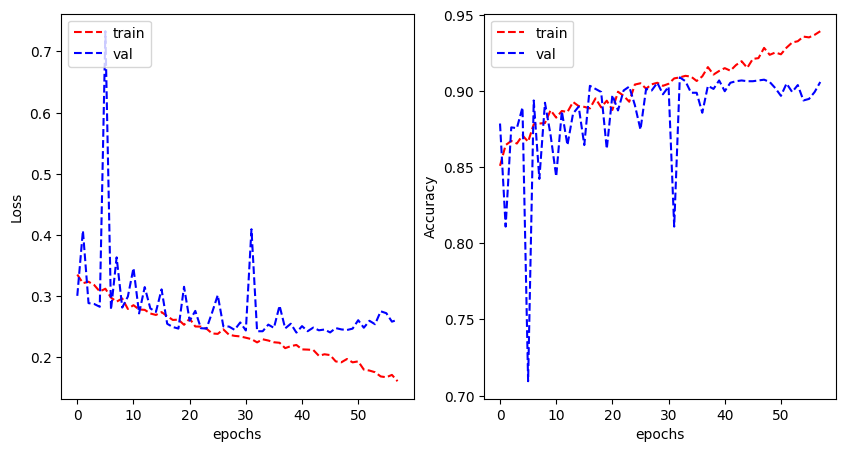

In [25]:
plot_learning_curve(history_VGG_best.history['loss'], history_VGG_best.history['val_loss'], 
                    history_VGG_best.history['categorical_accuracy'], history_VGG_best.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [26]:
(train_y, train_VGG_best_pred_y) = predictModel(best_VGG, train_generator)

Time Taken to Predict the Model =  0:05:37.884364


In [27]:
(val_y, val_VGG_best_pred_y) = predictModel(best_VGG, validation_generator)

Time Taken to Predict the Model =  0:02:38.985694


In [28]:
(test_y, test_VGG_best_pred_y) = predictModel(best_VGG, test_generator)

Time Taken to Predict the Model =  0:03:19.045887


In [29]:
showMetrics(train_y, train_VGG_best_pred_y)

Accuracy score:  0.9569119718867237
F1 score:  0.9556256682675713
              precision    recall  f1-score   support

           0       0.96      0.97      0.96    110418
           1       0.95      0.94      0.95     79101

    accuracy                           0.96    189519
   macro avg       0.96      0.95      0.96    189519
weighted avg       0.96      0.96      0.96    189519



In [30]:
showMetrics(val_y, val_VGG_best_pred_y)

Accuracy score:  0.9060991246260269
F1 score:  0.9027549488867035
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     37316
           1       0.89      0.88      0.88     25857

    accuracy                           0.91     63173
   macro avg       0.90      0.90      0.90     63173
weighted avg       0.91      0.91      0.91     63173



In [31]:
showMetrics(test_y, test_VGG_best_pred_y)

Accuracy score:  0.9050540831172117
F1 score:  0.9007994447282661
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     37974
           1       0.89      0.87      0.88     25262

    accuracy                           0.91     63236
   macro avg       0.90      0.90      0.90     63236
weighted avg       0.90      0.91      0.90     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

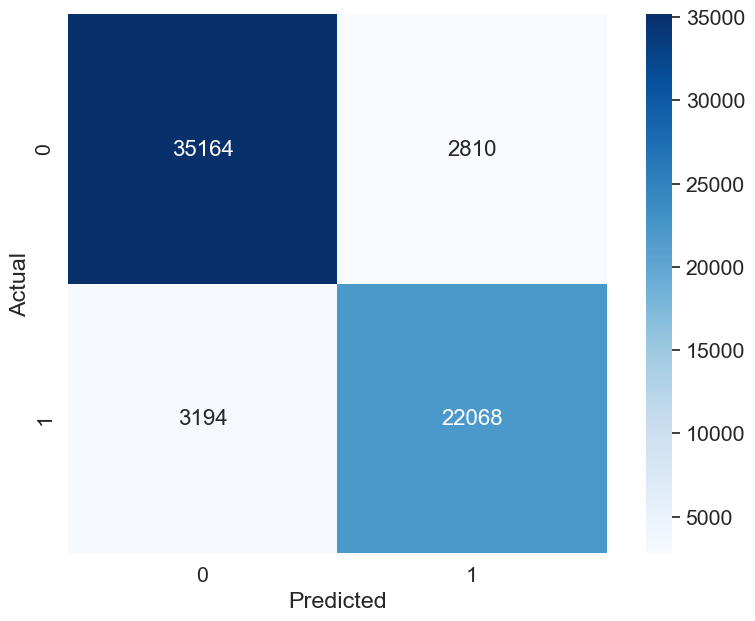

In [32]:
plotConfusionMatrix(test_y, test_VGG_best_pred_y)

Key Observations:

- Improved Performance: The model with optimized hyperparameters achieved higher accuracy, precision, recall, and F1 scores on the training, validation, and test datasets compared to the previous VGG with dropout model.

- Generalization and Robustness: The model demonstrated improved generalization ability with consistent performance across different datasets.

- Handling Class Imbalance: The model's performance for both the majority (non-cancerous) and minority (cancerous) classes improved.

- Trade-off between Precision and Recall: The model achieved relatively high precision and recall for both classes, striking a balance between correctly identifying cancerous cases (recall) and minimizing false positives (precision).

Overall, by applying hyperparameter tuning to the VGG architecture with dropout, the model achieved improved performance, generalization, class balance handling, and an optimal trade-off between precision and recall. So far this is our best model yet, however, we will try to further explore other advanced models in order to try and improve performance.

## VGG 3 BLOCK:
In order to further enhance our model's performance, we will now explore a more advanced 3-layer VGG model after our 2-block model.

In [18]:
model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid' )
])

In [19]:
model_VGG_3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [20]:
history_VGG_3 = fitModel(model_VGG_3)

Epoch 1/100
186/186 [==============================] - 42s 225ms/step - loss: 0.6752 - categorical_accuracy: 0.5826 - val_loss: 0.6666 - val_categorical_accuracy: 0.5907
Epoch 2/100
186/186 [==============================] - 11s 60ms/step - loss: 0.6653 - categorical_accuracy: 0.5826 - val_loss: 0.6522 - val_categorical_accuracy: 0.5907
Epoch 3/100
186/186 [==============================] - 11s 60ms/step - loss: 0.6393 - categorical_accuracy: 0.6092 - val_loss: 0.6509 - val_categorical_accuracy: 0.5902
Epoch 4/100
186/186 [==============================] - 11s 57ms/step - loss: 0.6050 - categorical_accuracy: 0.6763 - val_loss: 0.5165 - val_categorical_accuracy: 0.7453
Epoch 5/100
186/186 [==============================] - 11s 58ms/step - loss: 0.5645 - categorical_accuracy: 0.7224 - val_loss: 0.4657 - val_categorical_accuracy: 0.8338
Epoch 6/100
186/186 [==============================] - 10s 56ms/step - loss: 0.5299 - categorical_accuracy: 0.7509 - val_loss: 0.5050 - val_categorical_ac

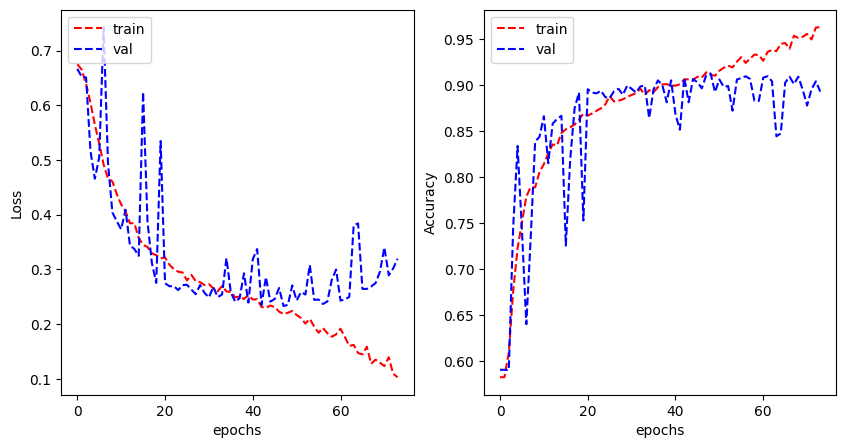

In [21]:
plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['categorical_accuracy'], history_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [22]:
(train_y, train_VGG_3_pred_y) = predictModel(model_VGG_3, train_generator)

Time Taken to Predict the Model =  0:06:53.059823


In [23]:
(val_y, val_VGG_3_pred_y) = predictModel(model_VGG_3, validation_generator)

Time Taken to Predict the Model =  0:03:11.542011


In [24]:
(test_y, test_VGG_3_pred_y) = predictModel(model_VGG_3, test_generator)

Time Taken to Predict the Model =  0:04:28.637370


In [25]:
showMetrics(train_y, train_VGG_3_pred_y)

Accuracy score:  0.9785667927753946
F1 score:  0.9779884082927991
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    110424
           1       0.97      0.98      0.97     79095

    accuracy                           0.98    189519
   macro avg       0.98      0.98      0.98    189519
weighted avg       0.98      0.98      0.98    189519



In [26]:
showMetrics(val_y, val_VGG_3_pred_y)

Accuracy score:  0.8928023047821063
F1 score:  0.8899392301574166
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     37322
           1       0.85      0.89      0.87     25851

    accuracy                           0.89     63173
   macro avg       0.89      0.89      0.89     63173
weighted avg       0.89      0.89      0.89     63173



In [27]:
showMetrics(test_y, test_VGG_3_pred_y)

Accuracy score:  0.903061547219938
F1 score:  0.8995038535033504
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     37982
           1       0.87      0.90      0.88     25254

    accuracy                           0.90     63236
   macro avg       0.90      0.90      0.90     63236
weighted avg       0.90      0.90      0.90     63236



In [ ]:
plotConfusionMatrix(test_y, test_VGG_3_pred_y)

Key Observations:

- Similar Performance: The VGG-3 Block model achieved comparable accuracy, precision, recall, and F1 scores on the training, validation, and test datasets to the 2 block VGG model. 

- Possible Saturation: The base 2 block VGG model already reached a high level of performance, and the additional block may have led to diminishing returns. 

- Dataset Complexity: The dataset used for training may not possess sufficient complexity that would benefit from the extra layer in the VGG-3 Block model.

Considering the similar performance between the VGG-3 Block and 2 block VGG models, it may be not be worth exploring other architectural modifications. However, we do try and apply Dropout to the model to try and get better performance.

## 3-Block VGG + Dropout:

In [18]:
model_VGG_3_DROP = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid' )
])

In [19]:
model_VGG_3_DROP.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [20]:
history_VGG_3_DROP = fitModel(model_VGG_3_DROP)

Epoch 1/100
186/186 [==============================] - 38s 201ms/step - loss: 0.6832 - categorical_accuracy: 0.5668 - val_loss: 0.6721 - val_categorical_accuracy: 0.5907
Epoch 2/100
186/186 [==============================] - 10s 53ms/step - loss: 0.6726 - categorical_accuracy: 0.5826 - val_loss: 0.6662 - val_categorical_accuracy: 0.5907
Epoch 3/100
186/186 [==============================] - 10s 54ms/step - loss: 0.6682 - categorical_accuracy: 0.5826 - val_loss: 0.6610 - val_categorical_accuracy: 0.5907
Epoch 4/100
186/186 [==============================] - 10s 56ms/step - loss: 0.6615 - categorical_accuracy: 0.5826 - val_loss: 0.6510 - val_categorical_accuracy: 0.5907
Epoch 5/100
186/186 [==============================] - 10s 53ms/step - loss: 0.6446 - categorical_accuracy: 0.5863 - val_loss: 0.6201 - val_categorical_accuracy: 0.6311
Epoch 6/100
186/186 [==============================] - 10s 53ms/step - loss: 0.5974 - categorical_accuracy: 0.6694 - val_loss: 0.6622 - val_categorical_ac

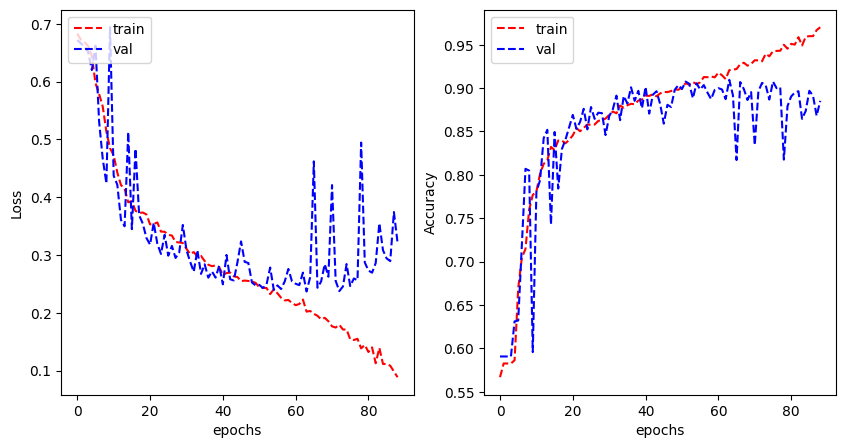

In [21]:
plot_learning_curve(history_VGG_3_DROP.history['loss'], history_VGG_3_DROP.history['val_loss'], 
                    history_VGG_3_DROP.history['categorical_accuracy'], history_VGG_3_DROP.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [22]:
(train_y, train_VGG_3_DROP_pred_y) = predictModel(model_VGG_3_DROP, train_generator)

Time Taken to Predict the Model =  0:05:57.589980


In [23]:
(val_y, val_VGG_3_DROP_pred_y) = predictModel(model_VGG_3_DROP, validation_generator)

Time Taken to Predict the Model =  0:03:01.492125


In [24]:
(test_y, test_VGG_3_DROP_pred_y) = predictModel(model_VGG_3_DROP, test_generator)

Time Taken to Predict the Model =  0:03:35.519927


In [25]:
showMetrics(train_y, train_VGG_3_DROP_pred_y)

Accuracy score:  0.9877162711918066
F1 score:  0.9873933283524914
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    110419
           1       0.98      0.99      0.99     79100

    accuracy                           0.99    189519
   macro avg       0.99      0.99      0.99    189519
weighted avg       0.99      0.99      0.99    189519



In [26]:
showMetrics(val_y, val_VGG_3_DROP_pred_y)

Accuracy score:  0.8853307583936175
F1 score:  0.8826735856859488
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     37319
           1       0.83      0.90      0.87     25854

    accuracy                           0.89     63173
   macro avg       0.88      0.89      0.88     63173
weighted avg       0.89      0.89      0.89     63173



In [27]:
showMetrics(test_y, test_VGG_3_DROP_pred_y)

Accuracy score:  0.8920077171231577
F1 score:  0.8886398937620424
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     37977
           1       0.84      0.90      0.87     25259

    accuracy                           0.89     63236
   macro avg       0.89      0.89      0.89     63236
weighted avg       0.89      0.89      0.89     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

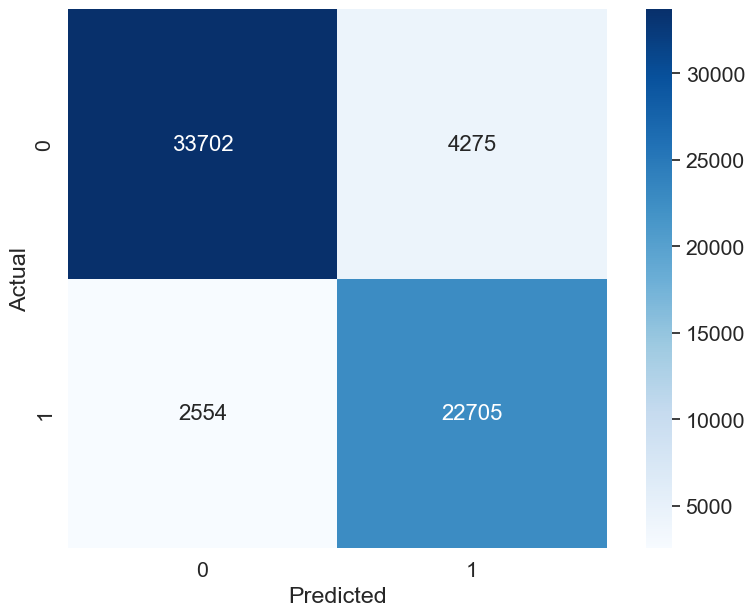

In [28]:
plotConfusionMatrix(test_y, test_VGG_3_DROP_pred_y)

Key Observations:

- Increased Overfitting: The VGG-3 model with dropout regularization exhibited a higher accuracy, precision, recall, and F1 scores on the training dataset compared to the validation and test datasets.

- Reduced Generalization: The wider performance gap between the training and validation/test datasets indicates that the model's ability to generalize has been compromised.

- Complexity and Model Capacity: The VGG-3 model, with its additional block and dropout layers, increased the complexity and capacity of the model.

The addition of dropout to the VGG-3 model led to increased overfitting and reduced performance on the validation and test datasets. This Model does not seem to perform well and is not worth exploring further.

<b> 2-Block VGG Architecture is still our best Model so far </b>

VGG-3 might be too complex for our task, we will further explore the LeNet model for a comparison of performance between a simpler architecture and a deeper architecture.

## LeNet:
The LeNet model is useful for our dataset as it is designed to effectively capture spatial features in images, which can be beneficial for our classification task.

In [18]:
model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [19]:
model_leNet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [20]:
history_leNet = fitModel(model_leNet)

Epoch 1/100
186/186 [==============================] - 37s 193ms/step - loss: 0.6712 - categorical_accuracy: 0.5826 - val_loss: 0.6624 - val_categorical_accuracy: 0.5907
Epoch 2/100
186/186 [==============================] - 3s 18ms/step - loss: 0.6635 - categorical_accuracy: 0.5826 - val_loss: 0.6560 - val_categorical_accuracy: 0.5907
Epoch 3/100
186/186 [==============================] - 3s 18ms/step - loss: 0.6564 - categorical_accuracy: 0.5826 - val_loss: 0.6480 - val_categorical_accuracy: 0.5907
Epoch 4/100
186/186 [==============================] - 3s 18ms/step - loss: 0.6470 - categorical_accuracy: 0.5826 - val_loss: 0.6356 - val_categorical_accuracy: 0.5907
Epoch 5/100
186/186 [==============================] - 3s 18ms/step - loss: 0.6320 - categorical_accuracy: 0.5897 - val_loss: 0.6143 - val_categorical_accuracy: 0.6124
Epoch 6/100
186/186 [==============================] - 3s 18ms/step - loss: 0.6068 - categorical_accuracy: 0.6323 - val_loss: 0.5843 - val_categorical_accurac

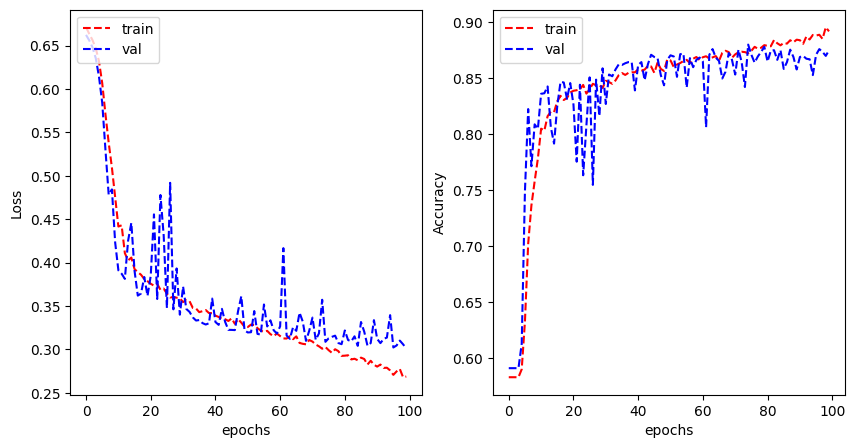

In [21]:
plot_learning_curve(history_leNet.history['loss'], history_leNet.history['val_loss'], 
                    history_leNet.history['categorical_accuracy'], history_leNet.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [22]:
(train_y, train_leNet_pred_y) = predictModel(model_leNet, train_generator)

Time Taken to Predict the Model =  0:05:25.623167


In [23]:
(val_y, val_leNet_pred_y) = predictModel(model_leNet, validation_generator)

Time Taken to Predict the Model =  0:02:13.525085


In [24]:
(test_y, test_leNet_pred_y) = predictModel(model_leNet, test_generator)

Time Taken to Predict the Model =  0:02:38.899981


In [25]:
showMetrics(train_y, train_leNet_pred_y)

Accuracy score:  0.900600995150882
F1 score:  0.8971162641135737
              precision    recall  f1-score   support

           0       0.90      0.93      0.92    110408
           1       0.90      0.86      0.88     79111

    accuracy                           0.90    189519
   macro avg       0.90      0.89      0.90    189519
weighted avg       0.90      0.90      0.90    189519



In [26]:
showMetrics(val_y, val_leNet_pred_y)

Accuracy score:  0.8746458138761812
F1 score:  0.8695089617436333
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     37310
           1       0.86      0.83      0.84     25863

    accuracy                           0.87     63173
   macro avg       0.87      0.87      0.87     63173
weighted avg       0.87      0.87      0.87     63173



In [27]:
showMetrics(test_y, test_leNet_pred_y)

Accuracy score:  0.8652666202795876
F1 score:  0.8587626197620841
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     37976
           1       0.84      0.81      0.83     25260

    accuracy                           0.87     63236
   macro avg       0.86      0.86      0.86     63236
weighted avg       0.86      0.87      0.86     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

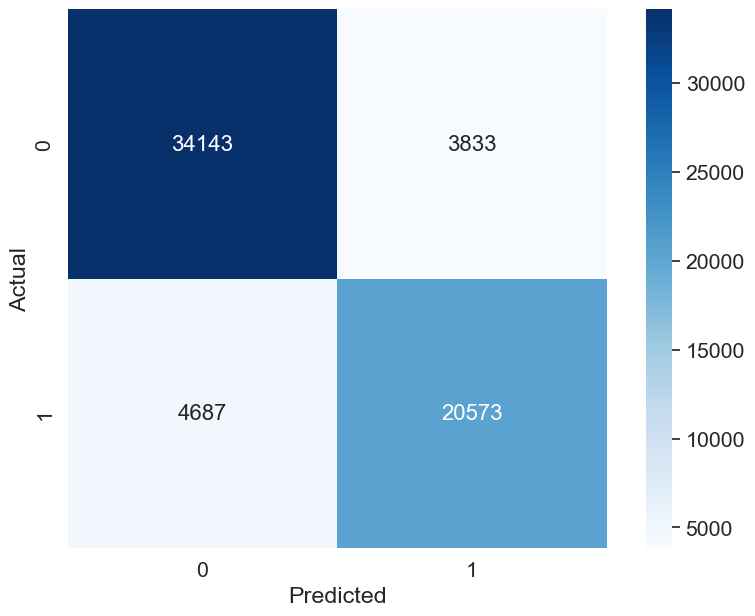

In [28]:
plotConfusionMatrix(test_y, test_leNet_pred_y)

Key Observations:

- LeNet architecture, despite its simplicity, still achieves reasonable accuracy and F1 scores on the training, validation, and testing datasets.

- It shows a balanced trade-off between precision and recall for both classes, indicating its ability to correctly identify cancerous cases while minimizing false positives.

- The performance of the LeNet model indicates a potential for slight overfitting as it achieves higher scores on the training set compared to the validation and testing sets.

However, compared to the VGG model, the LeNet model shows slightly lower accuracy, precision, recall, and F1 scores, suggesting that it may have a limited capacity to capture complex patterns in the data. 

It is worth further exploring the LeNet model to try and achieve the lowest Generalisation Gap.

## LeNet + Dropout

In [21]:
model_leNet_reg = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

In [22]:
model_leNet_reg.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [23]:
history_leNet_reg = fitModel(model_leNet_reg)

Epoch 1/100
186/186 [==============================] - 32s 167ms/step - loss: 0.6735 - categorical_accuracy: 0.5826 - val_loss: 0.6636 - val_categorical_accuracy: 0.5907
Epoch 2/100
186/186 [==============================] - 4s 19ms/step - loss: 0.6673 - categorical_accuracy: 0.5826 - val_loss: 0.6590 - val_categorical_accuracy: 0.5907
Epoch 3/100
186/186 [==============================] - 3s 18ms/step - loss: 0.6607 - categorical_accuracy: 0.5828 - val_loss: 0.6521 - val_categorical_accuracy: 0.5907
Epoch 4/100
186/186 [==============================] - 3s 17ms/step - loss: 0.6527 - categorical_accuracy: 0.5830 - val_loss: 0.6448 - val_categorical_accuracy: 0.5907
Epoch 5/100
186/186 [==============================] - 3s 17ms/step - loss: 0.6414 - categorical_accuracy: 0.5858 - val_loss: 0.6274 - val_categorical_accuracy: 0.5983
Epoch 6/100
186/186 [==============================] - 4s 19ms/step - loss: 0.6220 - categorical_accuracy: 0.6134 - val_loss: 0.6017 - val_categorical_accurac

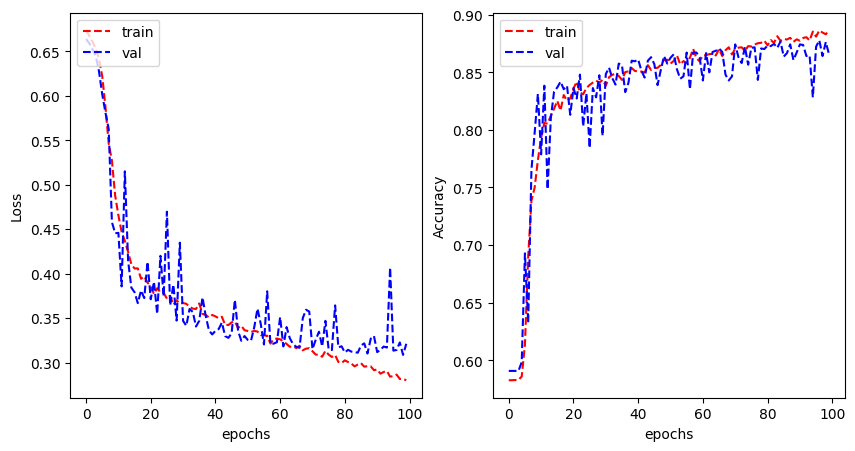

In [24]:
plot_learning_curve(history_leNet_reg.history['loss'], history_leNet_reg.history['val_loss'], 
                    history_leNet_reg.history['categorical_accuracy'], history_leNet_reg.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [25]:
(train_y, train_leNet_reg_pred_y) = predictModel(model_leNet_reg, train_generator)

Time Taken to Predict the Model =  0:05:46.981548


In [26]:
(val_y, val_leNet_reg_pred_y) = predictModel(model_leNet_reg, validation_generator)

Time Taken to Predict the Model =  0:02:06.297008


In [27]:
(test_y, test_leNet_reg_pred_y) = predictModel(model_leNet_reg, test_generator)

Time Taken to Predict the Model =  0:02:31.302791


In [28]:
showMetrics(train_y, train_leNet_reg_pred_y)

Accuracy score:  0.891198243975538
F1 score:  0.8890227053150705
              precision    recall  f1-score   support

           0       0.93      0.88      0.90    110424
           1       0.85      0.90      0.87     79095

    accuracy                           0.89    189519
   macro avg       0.89      0.89      0.89    189519
weighted avg       0.89      0.89      0.89    189519



In [29]:
showMetrics(val_y, val_leNet_reg_pred_y)

Accuracy score:  0.8655596536495022
F1 score:  0.8622487015502021
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     37315
           1       0.82      0.87      0.84     25858

    accuracy                           0.87     63173
   macro avg       0.86      0.87      0.86     63173
weighted avg       0.87      0.87      0.87     63173



In [30]:
showMetrics(test_y, test_leNet_reg_pred_y)

Accuracy score:  0.8671010184072364
F1 score:  0.8630483930267816
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     37968
           1       0.81      0.87      0.84     25268

    accuracy                           0.87     63236
   macro avg       0.86      0.87      0.86     63236
weighted avg       0.87      0.87      0.87     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

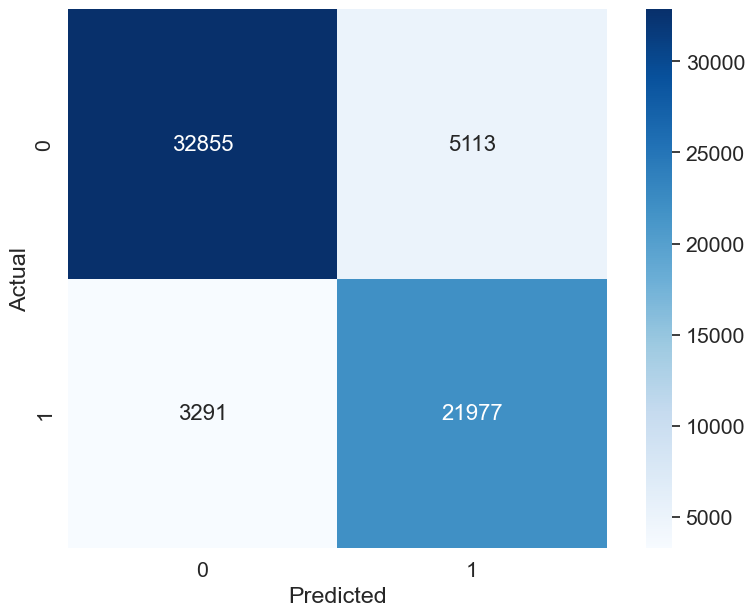

In [31]:
plotConfusionMatrix(test_y, test_leNet_reg_pred_y)

Key Observations:

- The drop in performance observed when applying dropout to the LeNet model could be attributed to the model's relatively small size and simplicity.

-  Applying dropout in our case lead to an unnecessary reduction in the model's learning capacity, resulting in lower performance.

This Model does not seem to perform well and is not worth exploring further.

<b> 2-Block VGG Architecture is still our best Model so far </b>

The LeNet Model is too simple for our task. Finally, we will try to Explore the RCCNet Model, which was specifically designed for our dataset.

## Recurrent Convolutional Neural Network (RCCNet):
RCCNet was specifically designed and tailored for the original CRCHistoPhenoTypes dataset, making it a potentially ideal choice for our specific dataset and its unique characteristics.

In [18]:
model_RCC = tf.keras.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(2, activation='sigmoid')
])

In [19]:
from keras.optimizers import Adam
adam = Adam(learning_rate=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model_RCC.compile(optimizer=adam,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [20]:
history_RCC = fitModel(model_RCC)

Epoch 1/100
186/186 [==============================] - 44s 230ms/step - loss: 0.5545 - categorical_accuracy: 0.7760 - val_loss: 1.8920 - val_categorical_accuracy: 0.4093
Epoch 2/100
186/186 [==============================] - 12s 62ms/step - loss: 0.3277 - categorical_accuracy: 0.8701 - val_loss: 1.7596 - val_categorical_accuracy: 0.4310
Epoch 3/100
186/186 [==============================] - 11s 61ms/step - loss: 0.2659 - categorical_accuracy: 0.8924 - val_loss: 0.7344 - val_categorical_accuracy: 0.6948
Epoch 4/100
186/186 [==============================] - 11s 60ms/step - loss: 0.2034 - categorical_accuracy: 0.9153 - val_loss: 0.2958 - val_categorical_accuracy: 0.8853
Epoch 5/100
186/186 [==============================] - 11s 60ms/step - loss: 0.1794 - categorical_accuracy: 0.9269 - val_loss: 0.2989 - val_categorical_accuracy: 0.8898
Epoch 6/100
186/186 [==============================] - 11s 61ms/step - loss: 0.1528 - categorical_accuracy: 0.9429 - val_loss: 0.3156 - val_categorical_ac

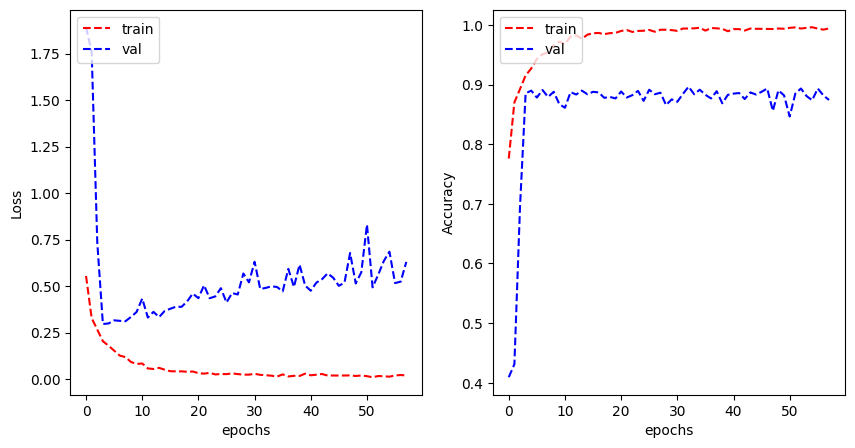

In [21]:
plot_learning_curve(history_RCC.history['loss'], history_RCC.history['val_loss'], 
                    history_RCC.history['categorical_accuracy'], history_RCC.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [22]:
(train_y, train_RCC_pred_y) = predictModel(model_RCC, train_generator)

Time Taken to Predict the Model =  0:06:52.868008


In [23]:
(val_y, val_RCC_pred_y) = predictModel(model_RCC, validation_generator)

Time Taken to Predict the Model =  0:03:50.744962


In [24]:
(test_y, test_RCC_pred_y) = predictModel(model_RCC, test_generator)

Time Taken to Predict the Model =  0:04:56.000552


In [25]:
showMetrics(train_y, train_RCC_pred_y)

Accuracy score:  0.9991663105018495
F1 score:  0.9991431459384011
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110419
           1       1.00      1.00      1.00     79100

    accuracy                           1.00    189519
   macro avg       1.00      1.00      1.00    189519
weighted avg       1.00      1.00      1.00    189519



In [26]:
showMetrics(val_y, val_RCC_pred_y)

Accuracy score:  0.8742184160954838
F1 score:  0.8720761970227897
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     37319
           1       0.81      0.91      0.86     25854

    accuracy                           0.87     63173
   macro avg       0.87      0.88      0.87     63173
weighted avg       0.88      0.87      0.88     63173



In [27]:
showMetrics(test_y, test_RCC_pred_y)

Accuracy score:  0.8702005186918844
F1 score:  0.8669162044140047
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     37975
           1       0.80      0.89      0.85     25261

    accuracy                           0.87     63236
   macro avg       0.86      0.87      0.87     63236
weighted avg       0.88      0.87      0.87     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

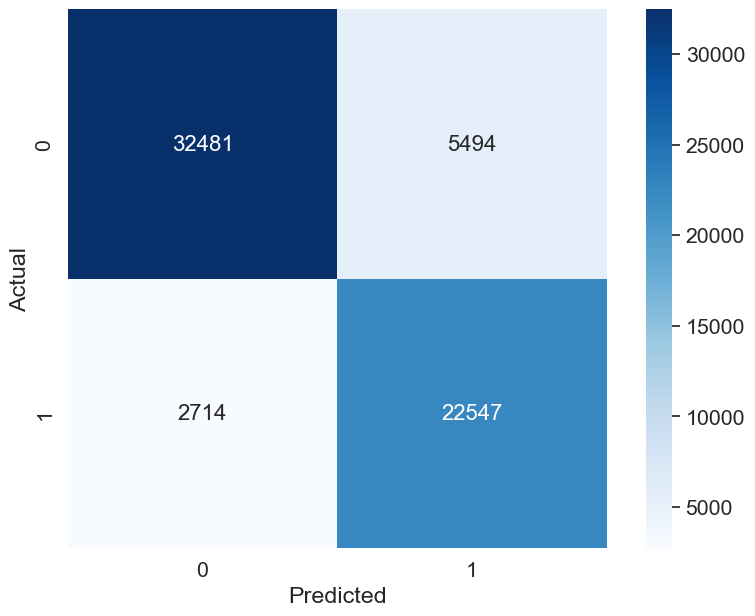

In [28]:
plotConfusionMatrix(test_y, test_RCC_pred_y)

We have tried to recreate the original RCCNet Architecture that was created for the CRCHistoPhenoTypes Dataset and included in the original parameter settings.

Key Observations:

- Although the RCCNet model achieved near-perfect performance on the training dataset, it did not outperform the VGG-2 model in terms of generalization and class imbalance handling. 

- Overfitting Issue: RCCNet suffers from a huge generalisation gap and shows overfitting. 

Although, RCCNet was specifically created for the original dataset, it is outperformed by VGG as:

- Image Resolution: The smaller size of the modified 27x27 images used in the VGG model may have resulted in the loss of some important details and fine-grained features present in the original RCCNet's input images. 

- Class Imbalances: The modified dataset used for training the VGG model had significant class imbalances, where one class had significantly more samples than the other, it could have influenced the model's performance. The RCCNet might have been more balanced in its approach, but its performance might have suffered due to class imbalance.

Therefore, it is not worth exploring RCCNet for our Cell Type Classification at all.

<b> Overall, we determine VGG-2 as our best performing Model as further explained in the report. </b>

----------------------